<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/neural_metalens_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


This may take a minute or two so be patient! We are working to optimize repository size and structure. 

In [1]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
fatal: destination path 'DFlat' already exists and is not an empty directory.


In [2]:
%cd /content/DFlat
!python setup.py develop

/content/DFlat
running develop
running egg_info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.8/dist-packages/DFlat.egg-link (link to .)
DFlat 2.3.0 is already the active version in easy-install.pth

Installed /content/DFlat
Processing dependencies for DFlat==2.3.0
Finished processing dependencies for DFlat==2.3.0


In [3]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Create a basic metasurface optimization pipeline using the PSF layer and the neural optical model 

A general pipeline class can be reused for different settings (e.g. neural models) or loss functions as defined in the next section! This is why we structure the software flow like this! 

We first import the dflat modules which include packaged routines that are compatible with the tf.keras framework


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

import dflat.optimization_helpers as df_optimizer
import dflat.fourier_layer as df_fourier
import dflat.neural_optical_layer as df_neural
import dflat.data_structure as df_struct
import dflat.plot_utilities as plt_util

We first build an optimization class inheriting from the df_optimizer.Pipeline_Object (although you can choose to not use this).

By inheriting this class, all the details of saving and loading custom model checkpoints are taken care of. Moreover, this class allows us to use convenient, pre-written functions for training loops, enabling faster prototyping.  

Most of the lines below are used to define the visualizeTrainingCheckpoint. This is a plotting functions that will be called during save checkpoints (intermediary epochs) to monitor the process when using the training helpers in the df_optimizer module! Defining this function overides the parent empy function and is entirely optional! If not included, no visualization plots will be made but the code will still run.

In the collab, these plots wont actually save since no google drive or harddrive is mounted but that is okay! we can always view plots manually at the end by tweaking the code and calling the function with plt.show()

In [8]:
class pipeline_Metalens_MLP(df_optimizer.Pipeline_Object):
    def __init__(self, propagation_parameters, point_source_locs, savepath, saveAtEpochs=None):
        super(pipeline_Metalens_MLP, self).__init__(savepath, saveAtEpochs)

        # Add inputs to class attributes
        self.propagation_parameters = propagation_parameters
        self.point_source_locs = point_source_locs

        # define computational layers
        mlp_model = "MLP_Nanocylinders_Dense64_U180_H600"
        self.mlp_latent_layer = df_neural.MLP_Latent_Layer(mlp_model)
        self.psf_layer = df_fourier.PSF_Layer_Mono(propagation_parameters)  # Note the other psf layers one can use

        # Define initial starting condition for the metasurface latent tensor
        init_latent_tensor = tf.zeros(propagation_parameters["grid_shape"], dtype=tf.float64)
        self.latent_tensor_variable = tf.Variable(init_latent_tensor, trainable=True, dtype=tf.float64)

        ## The lens could be initialized in another state like a focusing lens:
        # focus_trans, focus_phase, _, _ = df_fourier.focus_lens_init(propagation_parameters, [532e-9], [0.3], [{"x": 0, "y": 0}])
        # _, norm_param = df_library.optical_response_to_param([focus_trans], [focus_phase], [532e-9], "Nanocylinders_U180nm_H600nm", reshape=True)
        # init_latent_tensor = df_tools.param_to_latent(init_norm_param)
        # self.latent_tensor_variable = tf.Variable(init_latent_tensor, trainable=True, dtype=tf.float64)

        return

    def __call__(self):
        # Compute the PSF
        wavelength_m = self.propagation_parameters["wavelength_m"]
        out = self.mlp_latent_layer(self.latent_tensor_variable, [wavelength_m])
        psf_intensity, psf_phase = self.psf_layer(out, self.point_source_locs)

        # Save the last lens and psf for plotting later
        self.last_lens = out
        self.last_psf = psf_intensity

        return psf_intensity

    def visualizeTrainingCheckpoint(self, saveto):
        # This overrides the baseclass visualization call function, called during checkpoints
        savefigpath = self.savepath + "/trainingOutput/"
        radial_flag = self.propagation_parameters["radial_symmetry"]

        # Helper call that returns simple definition of cartesian axis on lens and output space (mm)
        xl, yl = plt_util.get_lens_pixel_coordinates(self.propagation_parameters)
        xd, yd = plt_util.get_detector_pixel_coordinates(self.propagation_parameters)
        xl, yl = xl * 1e3, yl * 1e3
        xd, yd = xd * 1e3, yd * 1e3

        # Plot Grab some items we want to visualize
        # Latent tensor can be converted back to the physical shape dimensions
        latent_tensor_state = self.latent_tensor_variable.numpy()
        shapeVector = np.squeeze(self.mlp_latent_layer.latent_to_unnorm_shape(latent_tensor_state))
        trans = np.squeeze(self.last_lens[0])
        phase = np.squeeze(self.last_lens[1])

        fig = plt.figure(figsize=(40, 10))
        axList = plt_util.addAxis(fig, 1, 3)
        lens_extent = (min(xl), max(xl), max(yl), min(yl))
        det_extent = (min(xd), max(xd), max(yd), min(yd))
        if radial_flag:
            axList[0].plot(xl, shapeVector * 1e9)
            plt_util.formatPlots(fig, axList[0], None, xlabel="lens x (mm)", ylabel="radius length (nm)", setAspect="auto")
            axList[1].plot(xl, phase, "bx-")
            axList[1].plot(xl, trans, "kx-")
            plt_util.formatPlots(fig, axList[1], None, xlabel="lens x (mm)", ylabel="Trans and Phase", setAspect="auto")
        else:
            im0 = axList[0].imshow(shapeVector * 1e9, extent=lens_extent)
            plt_util.formatPlots(
                fig,
                axList[0],
                im0,
                xlabel="lens x (mm)",
                ylabel="lens y (nm)",
                title="Learned Metasurface",
                setAspect="equal",
                addcolorbar=True,
                cbarTitle="Radius (nm)",
            )

            im1 = axList[1].imshow(phase, extent=lens_extent, vmin=-np.pi, vmax=np.pi)
            plt_util.formatPlots(
                fig,
                axList[1],
                im1,
                xlabel="lens x (mm)",
                ylabel="lens y (mm)",
                title="Learned Phase",
                setAspect="equal",
                addcolorbar=True,
                cbarTitle="Phase (radians)",
            )

        # Plot the recent PSF
        im = axList[2].imshow(self.last_psf[0, 0], extent=det_extent)
        plt_util.formatPlots(
            fig, axList[2], im, xlabel="det x (mm)", ylabel="det y (mm)", title="PSF Intensity", addcolorbar=True, setAspect="equal"
        )

        plt.savefig(savefigpath + "png_images/" + saveto + "epoch_checkpointFig.png")
        plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_checkpointFig.pdf")
        #plt.close()
        plt.show()
        return

# Define Simulation Settings and run the optimization

We can write a simple function that will initialize our optimization pipeline class and train it! 

In this example, we will not write a custom, new training loop. Instead, we will import and use df_optimizer.run_pipeline_optimization function. This takes in a class that inherits df_optimizer.Pipeline_Object like done above.  

To train with this call, we define a loss function. Below, this is done in loss_fn. Note that currently when using this approach, the loss function can only take "pipeline_output" as an input! This means that the loss function should be defined explicitly in terms of the pipeline call function. 

If you do not like this, a new custom trainer can be written. An example on how to do this will be shown later but you can also open up and see the code in the df_optimizer.run_pipeline_optimization function to get an idea. Alternatively, you can also read the Tensorflow tutorial on gradient optimization. 


In [10]:
def optimize_metalens_mlp(radial_symmetry, num_epochs=30, try_gpu=True):
  savepath = "examples/output/metalens_example_radial" + str(radial_symmetry) + "/"
  if not os.path.exists(savepath):
      os.makedirs(savepath)

  # Define propagation parameters for psf calculation
  propagation_parameters = df_struct.prop_params(
      {
          "wavelength_m": 532e-9,  # wavelength_set_m would be used if the PSF_layer was used instead of psf_layer_mono
          "ms_samplesM": {"x": 555, "y": 555},
          "ms_dx_m": {"x": 10 * 180e-9, "y": 10 * 180e-9},
          "radius_m": 1.0e-3 / 2.0,
          "sensor_distance_m": 10e-3,
          "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
          "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
          "sensor_pixel_number": {"x": 501, "y": 501},
          "radial_symmetry": radial_symmetry,
          #"diffractionEngine": "fresnel_fourier", #You can also use ASM_fourier for the angular spectrum method calculation
          "diffractionEngine": "ASM_fourier", #You can also use ASM_fourier for the angular spectrum method calculation
          ### Optional keys
          "automatic_upsample": False,  # If true, it will try to automatically determine good upsample factor for calculations
          "manual_upsample_factor": 1,  # Otherwise you can manually dictate upsample factor
      },
      verbose=True,
  )

  # Point_source locs we want to compute the psf for
  point_source_locs = np.array([[0.0, 0.0, 1e6]])  # on-axis ps at 1e6 m away (~infinity)

  # Call the pipeline
  saveAtEpoch = 10 
  pipeline = pipeline_Metalens_MLP(propagation_parameters, point_source_locs, savepath, saveAtEpochs=saveAtEpoch)
  # pipeline.customLoad()  # restore previous training checkpoint if it exists

  # Define custom Loss function (Should always have pipeline_output as the function input if you use the helper)
  # Otherwise you can easily write your own train loop for more control
  sensor_pixel_number = propagation_parameters["sensor_pixel_number"]
  cidx_y = sensor_pixel_number["y"] // 2
  cidx_x = sensor_pixel_number["x"] // 2

  def loss_fn(pipeline_output):
      return -pipeline_output[0, 0, cidx_y, cidx_x]

  learning_rate = 2e-2
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  df_optimizer.run_pipeline_optimization(pipeline, optimizer, num_epochs=num_epochs, loss_fn=tf.function(loss_fn), allow_gpu=try_gpu)
  return

Run with radial symmetry Flag. Only a radial vector for the metasurface is trained and fields are propagated using an efficient, approximate Hankel transform


 OVERVIEW OF PARAMETERS 


 ms_length_m:  {'x': 0.0009989999999999999, 'y': 0.0009989999999999999}

 ms_dx_m:  {'x': 1.8e-06, 'y': 1.8e-06}

 calc_ms_dx_m:  {'x': 1e-06, 'y': 1e-06}

 ms_samplesM:  {'x': 555, 'y': 555, 'r': 278}

 calc_samplesM:  {'x': 999, 'y': 999, 'r': 500}

 calc_samplesN:  {'x': 999, 'y': 999, 'r': 500}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_size_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_number:  {'x': 501, 'y': 501}


Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense64_U180_H600/

 Model Checkpoint Loaded 



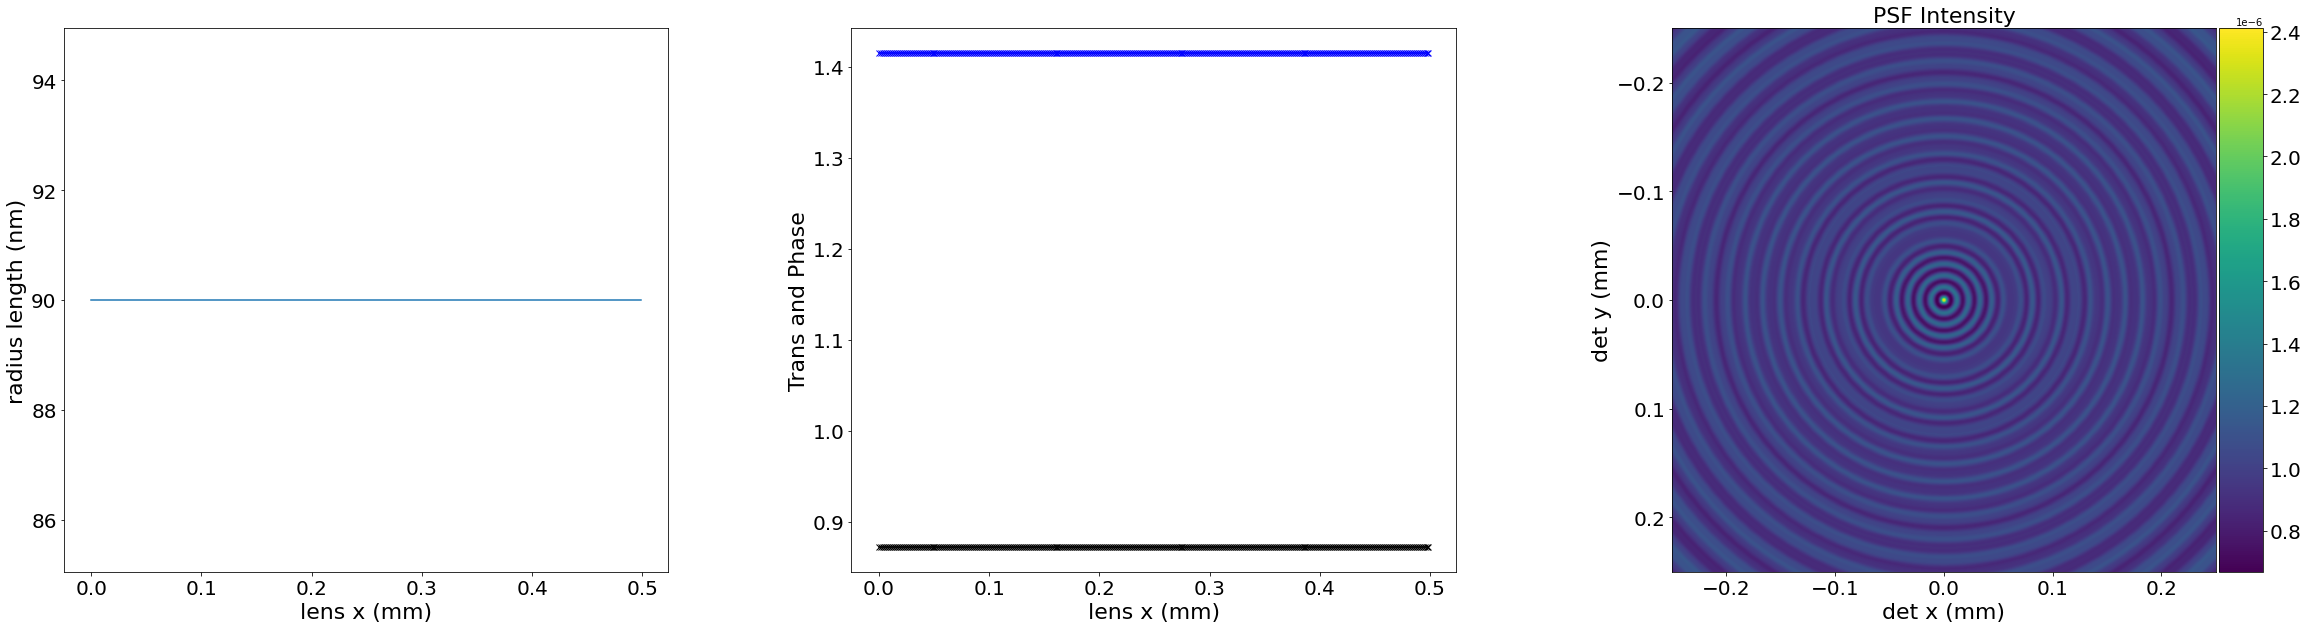

Training Log | (Step, time, loss):  0 3.4332497119903564 -2.4110878847211475e-06
Training Log | (Step, time, loss):  1 3.142850399017334 -0.0004747780300769056
Training Log | (Step, time, loss):  2 3.2011396884918213 -0.0013788497011439913
Training Log | (Step, time, loss):  3 3.168962001800537 -0.0026925137735235197
Training Log | (Step, time, loss):  4 3.1299848556518555 -0.004168362052970114
Training Log | (Step, time, loss):  5 3.1603076457977295 -0.005801496535647699
Training Log | (Step, time, loss):  6 3.186383008956909 -0.0072591424047133615
Training Log | (Step, time, loss):  7 3.212888479232788 -0.008777735638260271
Training Log | (Step, time, loss):  8 3.149993896484375 -0.010441728046930127
Training Log | (Step, time, loss):  9 3.179069995880127 -0.013066289873685686
Log Training at step: 10


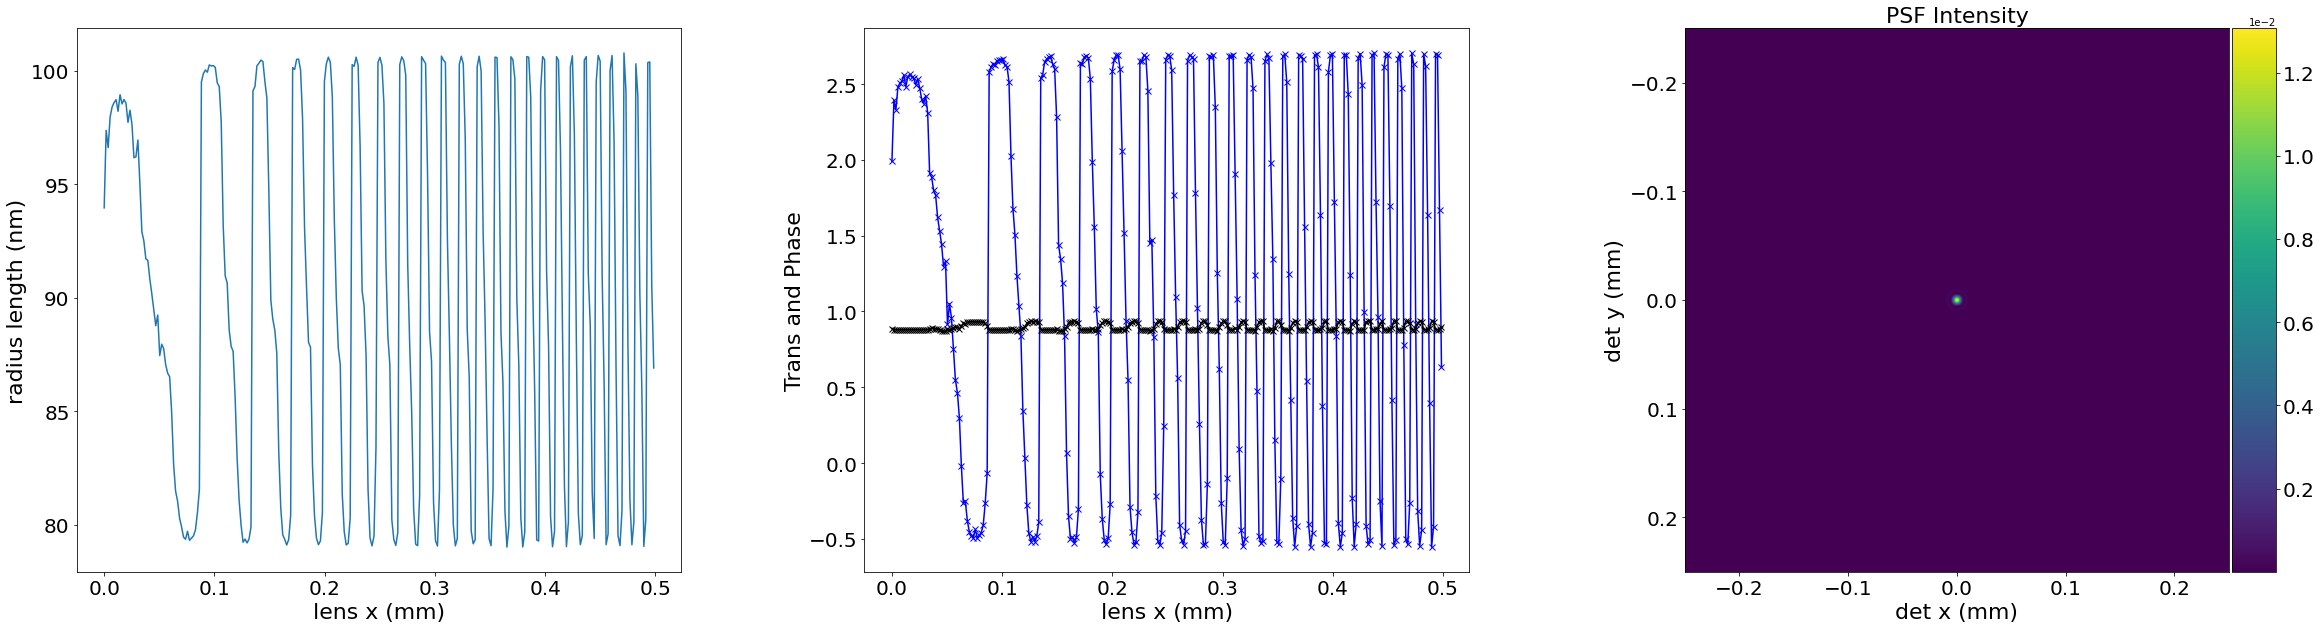

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  10 3.1900482177734375 -0.015766789816531464
Training Log | (Step, time, loss):  11 3.1890370845794678 -0.017091210696414574
Training Log | (Step, time, loss):  12 3.1726536750793457 -0.01795422700878614
Training Log | (Step, time, loss):  13 3.158188819885254 -0.018635641970744556
Training Log | (Step, time, loss):  14 3.166918992996216 -0.019090621852573743
Training Log | (Step, time, loss):  15 3.222726345062256 -0.019403732008972073
Training Log | (Step, time, loss):  16 3.2012295722961426 -0.019619977238180958
Training Log | (Step, time, loss):  17 3.2029552459716797 -0.019796534048407335
Training Log | (Step, time, loss):  18 3.257925033569336 -0.019923471068269617
Training Log | (Step, time, loss):  19 3.65844988822937 -0.02000520688992764
Log Training at step: 20


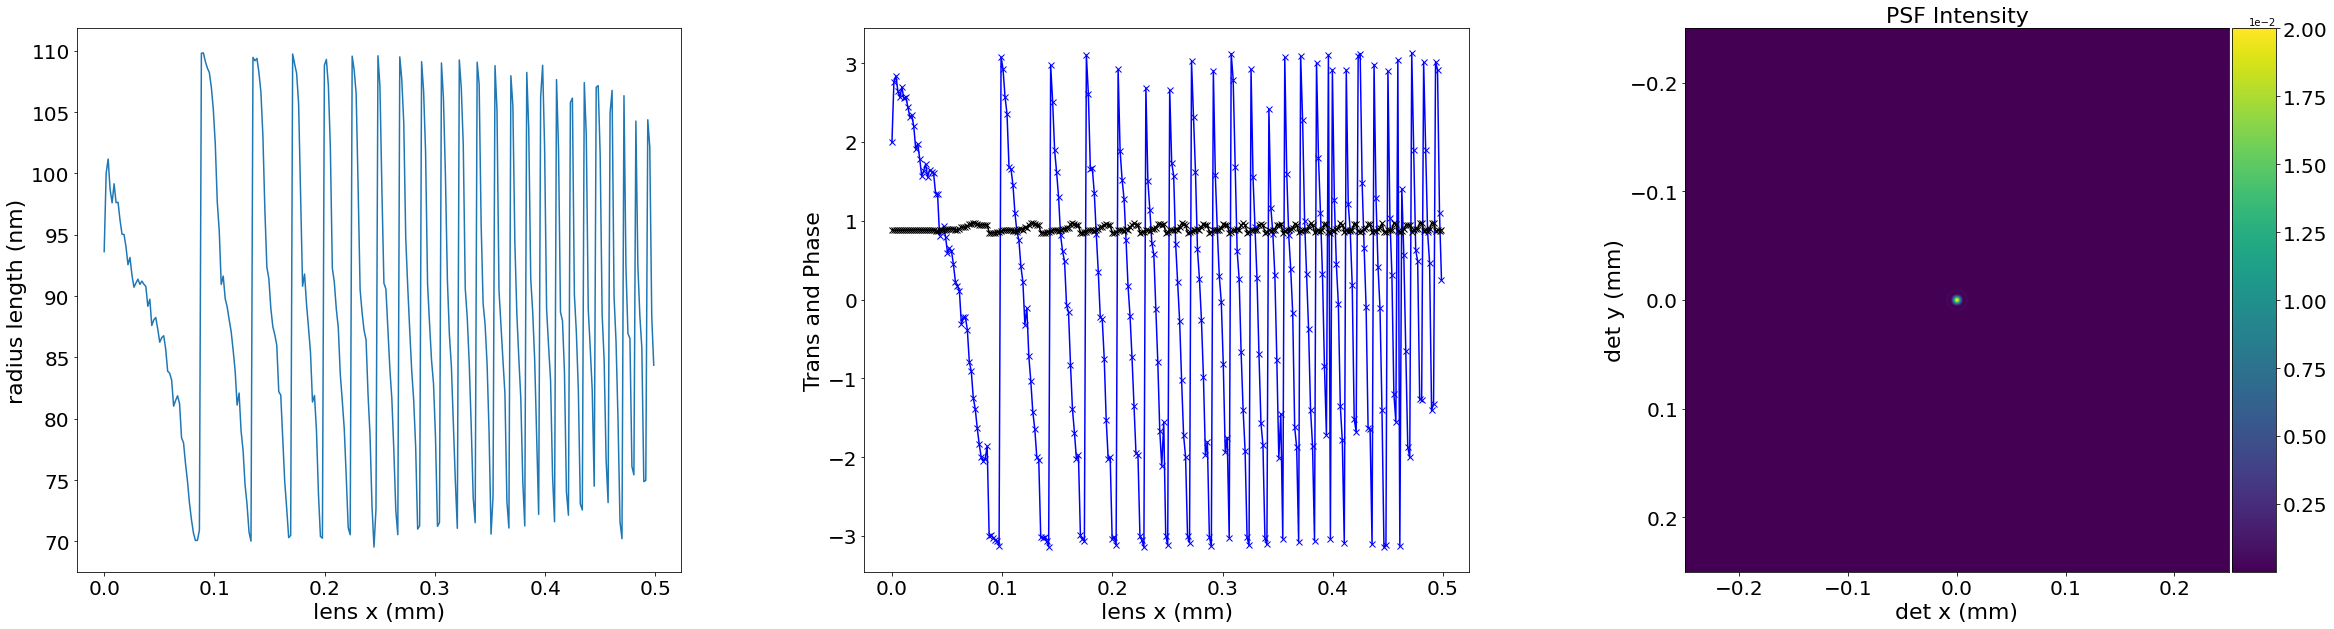

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  20 5.5084710121154785 -0.020078203597446335
Training Log | (Step, time, loss):  21 4.290165185928345 -0.020150843562016543
Training Log | (Step, time, loss):  22 4.257220029830933 -0.020218779362101872
Training Log | (Step, time, loss):  23 3.746202230453491 -0.02028017313163189
Training Log | (Step, time, loss):  24 4.875955820083618 -0.020340849130213754
Training Log | (Step, time, loss):  25 3.913303852081299 -0.02040207469886323
Training Log | (Step, time, loss):  26 4.117038726806641 -0.02047588840074428
Training Log | (Step, time, loss):  27 3.2044339179992676 -0.020559500394273192
Training Log | (Step, time, loss):  28 3.379396677017212 -0.020651670339950468
Training Log | (Step, time, loss):  29 3.8082237243652344 -0.020736777663885677
Log Training at step: 30


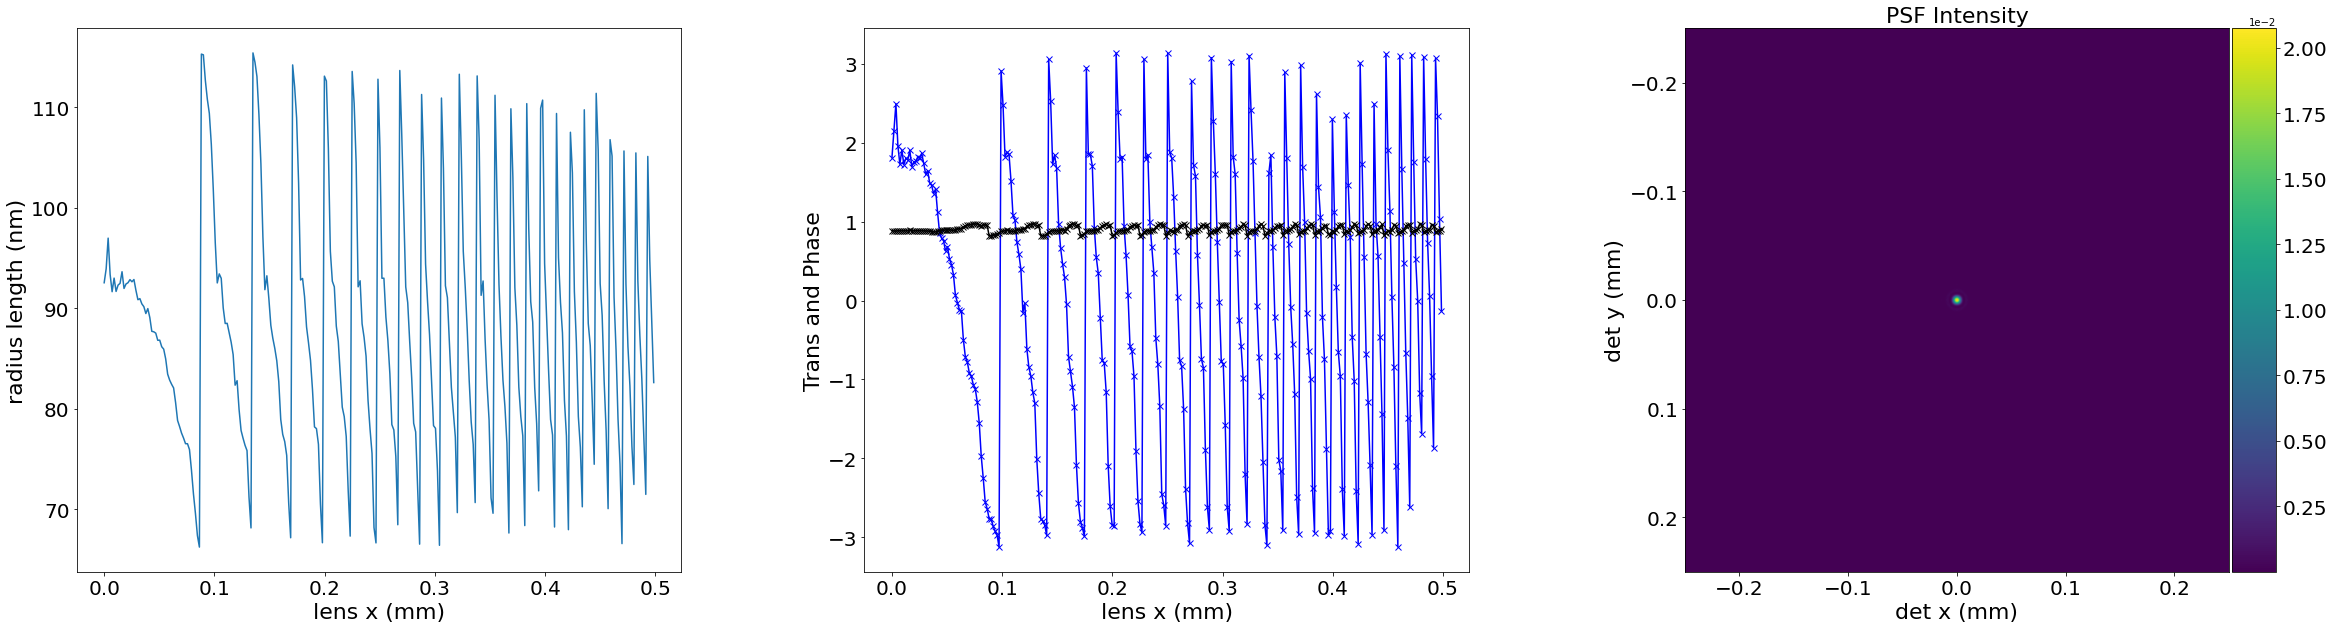

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))



 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


In [11]:
optimize_metalens_mlp(radial_symmetry=True, num_epochs=30, try_gpu=True)

Now run without radial symmetry Flag. The 2D metasurface will be assembled and 2D fields will be propagated instead. Cool, asymmetric PSFs can in theory be discovered like this but the memory costs are higher! Just like when training standard deep neural networks for computervision, DFlat can be paired with neural nets and should be trained on a GPU cluster or similar resources.


 OVERVIEW OF PARAMETERS 


 ms_length_m:  {'x': 0.0009989999999999999, 'y': 0.0009989999999999999}

 ms_dx_m:  {'x': 1.8e-06, 'y': 1.8e-06}

 calc_ms_dx_m:  {'x': 1e-06, 'y': 1e-06}

 ms_samplesM:  {'x': 555, 'y': 555, 'r': 278}

 calc_samplesM:  {'x': 999, 'y': 999, 'r': 500}

 calc_samplesN:  {'x': 999, 'y': 999, 'r': 500}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_size_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_number:  {'x': 501, 'y': 501}


Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense64_U180_H600/

 Model Checkpoint Loaded 



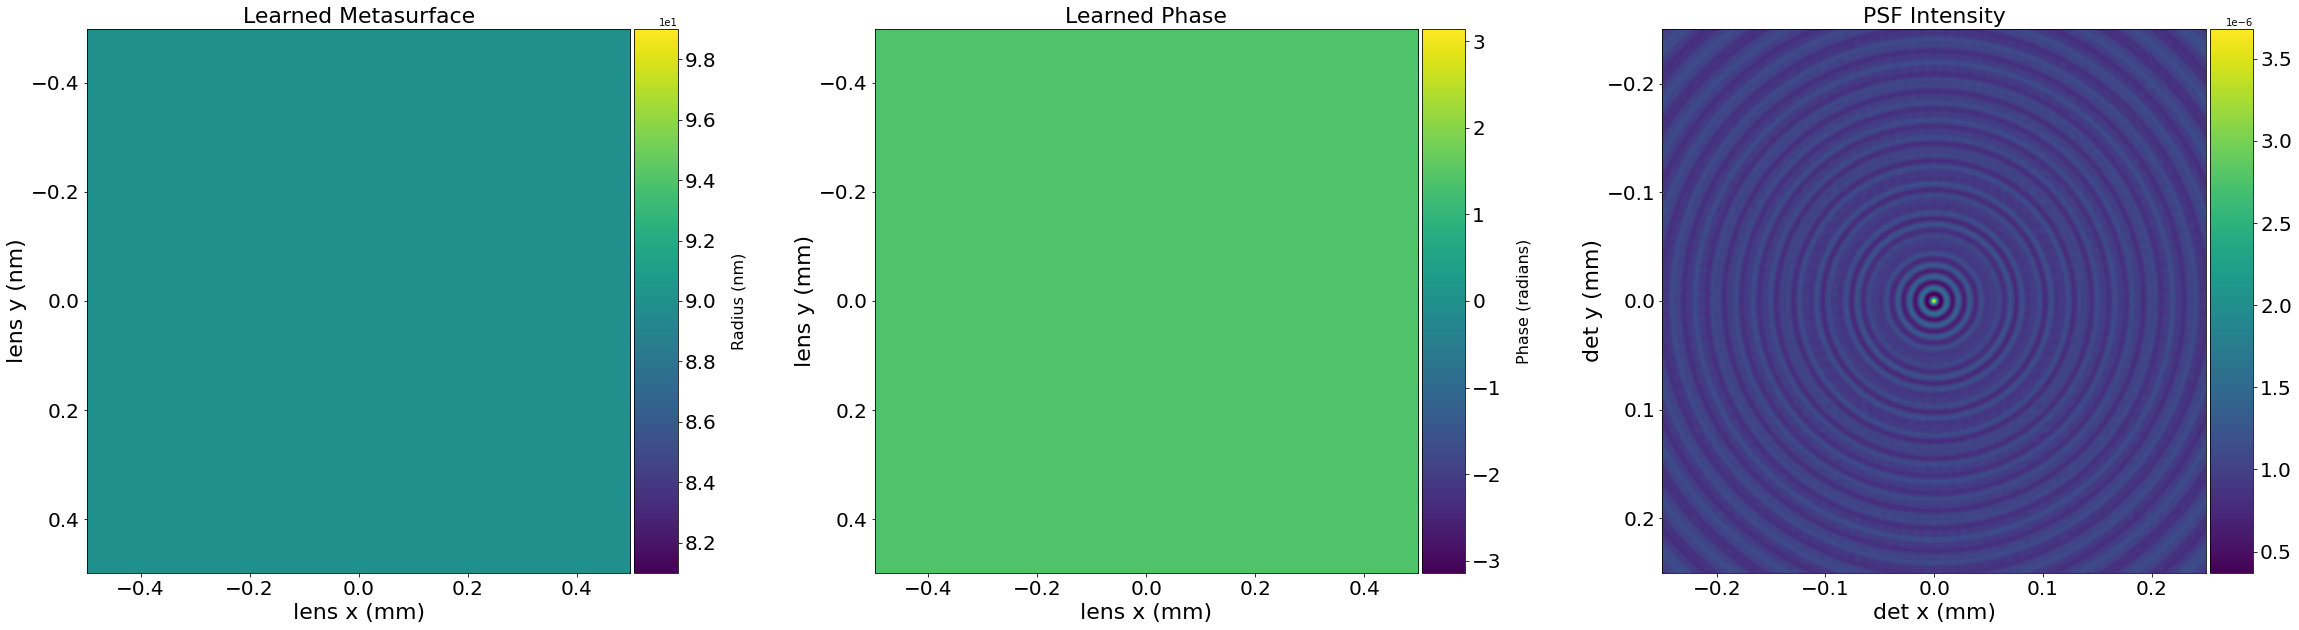

Training Log | (Step, time, loss):  0 0.6941220760345459 -3.6802303894611497e-06
Training Log | (Step, time, loss):  1 0.31456565856933594 -4.514507185668417e-06
Training Log | (Step, time, loss):  2 0.3123764991760254 -6.114264367808927e-06
Training Log | (Step, time, loss):  3 0.32636260986328125 -8.339627530208641e-06
Training Log | (Step, time, loss):  4 0.31420469284057617 -1.1797450314449825e-05
Training Log | (Step, time, loss):  5 0.3113412857055664 -1.6775119537912867e-05
Training Log | (Step, time, loss):  6 0.32663702964782715 -2.4010264449416028e-05
Training Log | (Step, time, loss):  7 0.3136253356933594 -3.443378142193405e-05
Training Log | (Step, time, loss):  8 0.3130979537963867 -4.942336630255446e-05
Training Log | (Step, time, loss):  9 0.31600069999694824 -7.112197259560753e-05
Log Training at step: 10


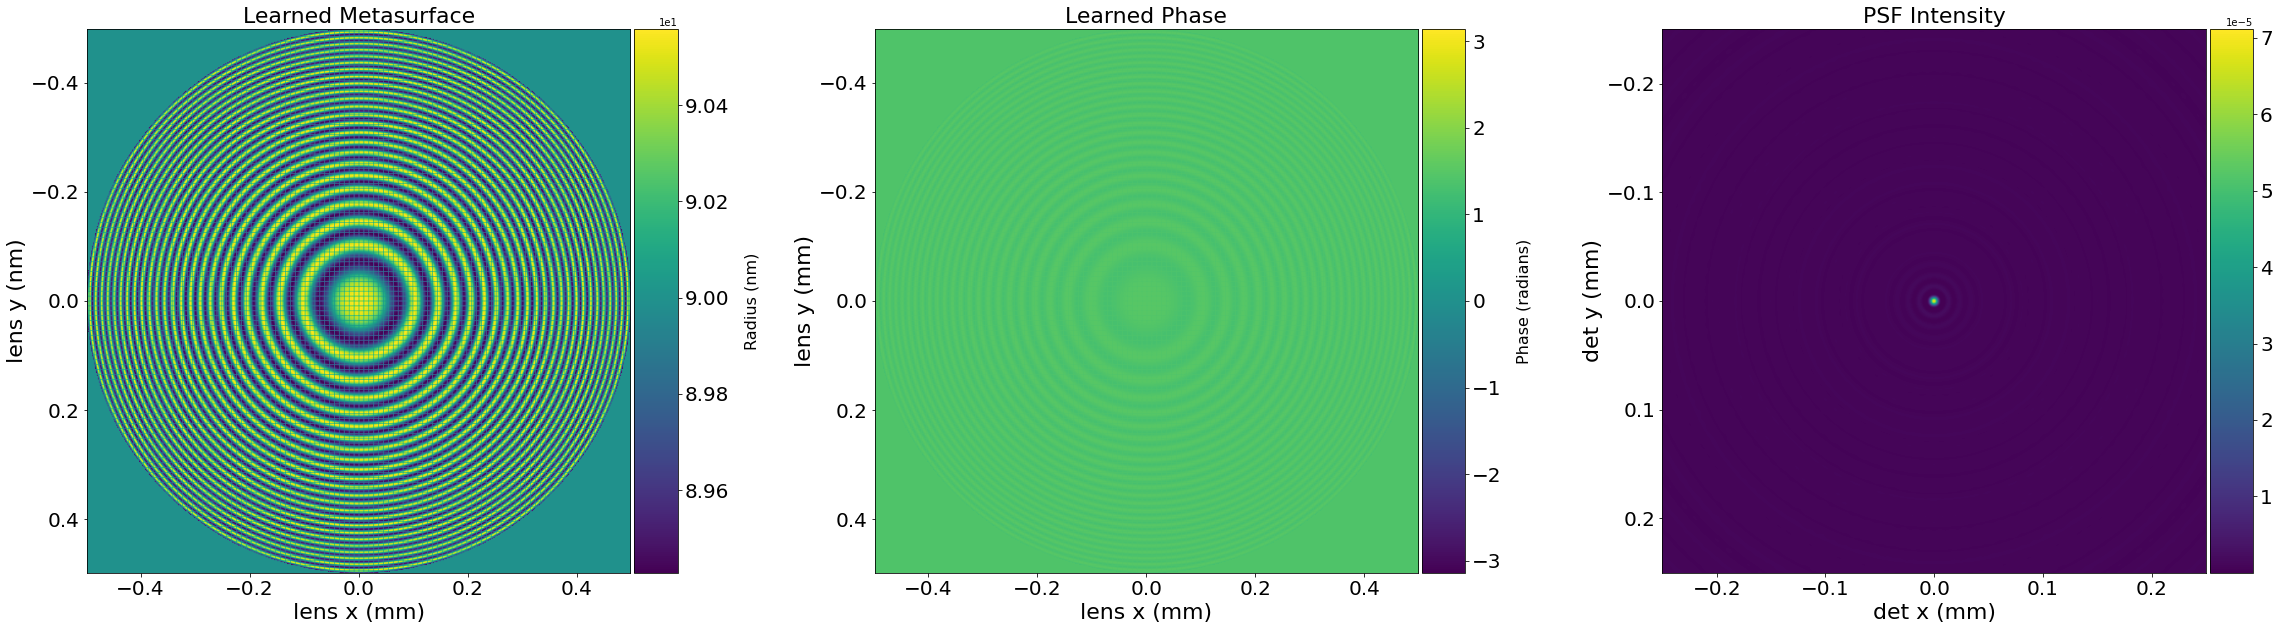

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  10 0.44166064262390137 -0.00010312929759350958
Training Log | (Step, time, loss):  11 0.3114604949951172 -0.0001496661023042913
Training Log | (Step, time, loss):  12 0.3183102607727051 -0.00021387482621962813
Training Log | (Step, time, loss):  13 0.3162720203399658 -0.0002998737625614111
Training Log | (Step, time, loss):  14 0.3125944137573242 -0.00041485665724386595
Training Log | (Step, time, loss):  15 0.32178330421447754 -0.000567170858713326
Training Log | (Step, time, loss):  16 0.3132929801940918 -0.000763543697779797
Training Log | (Step, time, loss):  17 0.31282711029052734 -0.0010122816785816085
Training Log | (Step, time, loss):  18 0.3123769760131836 -0.0013197944930384599
Training Log | (Step, time, loss):  19 0.3192601203918457 -0.0016935641329534773
Log Training at step: 20


Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  20 0.449357271194458 -0.002128486997206199
Training Log | (Step, time, loss):  21 0.31187868118286133 -0.0025930601358259762
Training Log | (Step, time, loss):  22 0.3128693103790283 -0.003085683961181952
Training Log | (Step, time, loss):  23 0.3163111209869385 -0.0036247541463638256
Training Log | (Step, time, loss):  24 0.3121178150177002 -0.0043005735550976695
Training Log | (Step, time, loss):  25 0.3140838146209717 -0.005061047900911665
Training Log | (Step, time, loss):  26 0.3143272399902344 -0.005922454143589679
Training Log | (Step, time, loss):  27 0.3176760673522949 -0.00682781428370339
Training Log | (Step, time, loss):  28 0.32004237174987793 -0.007782344742116627
Training Log | (Step, time, loss):  29 0.31771206855773926 -0.008780914313400383
Log Training at step: 30


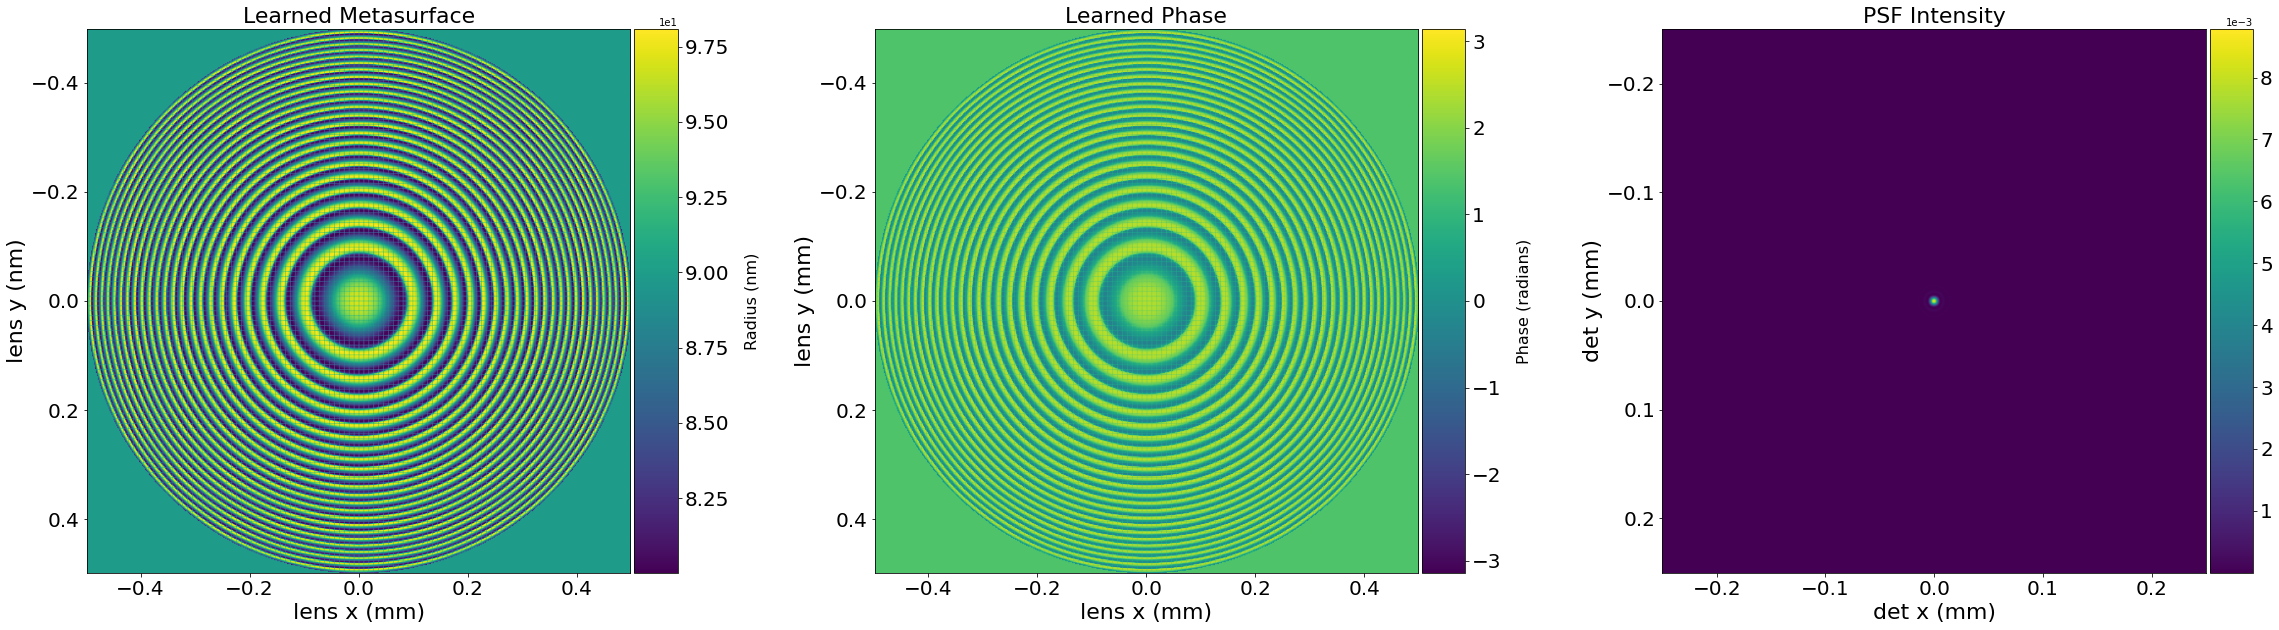

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))



 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


In [12]:
optimize_metalens_mlp(radial_symmetry=False, num_epochs=30, try_gpu=True)